# Clustring

For clustering I used PCA (and TSNE in the end of the notebook) together with KMeans, OPTICS and DBSCAN. 

KMeans togther with PCA showed the best DUNN and Silhuette scores. OPTICS produced too many clusters and was the worst in terms of dunn score, DBSCAN was in the middle, but it found only 3 clusters. However, with proper hyperparameters both DBSCAN and OPTICS, probably, may outperform KMeans, it is just hard and takes a lot of time to determine them.

In [1]:
import gensim.models as gs
import codecs
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, DBSCAN


model="./word2vec.bin"
test_docs_file="./test_docs.txt"
m = gs.Word2Vec.load(model)
w2v = m.wv
test_docs = [ list(map(str.lower,x.strip().split())) for x in codecs.open(test_docs_file, "r", "utf-8").readlines()]

vecs = np.array([np.sum(w2v[d], axis=0) for d in test_docs])

In [2]:
# Here are the functions that I used to make easier the training process and to make the code a bit cleaner. It is mostly training, outputin and plotting.

def kmeans_method(vecs, vocal=False):    
    kmeans_list = []
    for i in range(5,11):
        if vocal: print(i)
        kmeans = method_train_test(KMeans(n_clusters=i), vecs, vocal=False)
        kmeans_list.append(
            (davies_bouldin_score(vecs, kmeans.labels_),
            silhouette_score(vecs, kmeans.labels_),
            kmeans))
    res = max(kmeans_list, key = lambda i : i[0])
    print('Best k:', len(res[2].cluster_centers_))
    print("DUNN: ", res[0])
    print("Silhouette: ", res[1])
    print("Silhouette samples:", silhouette_samples(vecs, res[2].labels_))
    return res[2]

def method_train_test(method, vecs, vocal=True):
        meth = method.fit(vecs)
        if vocal:
            print("DUNN: ",davies_bouldin_score(vecs, meth.labels_))
            print("Silhouette mean: ",silhouette_score(vecs, meth.labels_))
            print("Silhouette samples:", silhouette_samples(vecs, meth.labels_))
        return meth


def print_data_labels(method, dataset):
    res = zip(method.labels_, dataset)
    di = {}
    for (key, data) in res:
        di.setdefault(key,[]).append(data)
    for (key, data) in sorted(di.items(), key=lambda item: item[0]):
        print(key, data)
    return di

def plot(method,dataset, title="Plot", columns = ['pc_1','pc_2']):
    df= pd.DataFrame(dataset, columns=columns)
    df['label'] = pd.Series(method.labels_, index=df.index)
    df.head()
    sn.scatterplot(data=df, x=columns[0], y=columns[1], hue="label", style="label", palette='deep')
    plt.title(title)
    plt.show()


def calc_variance(model, pca_dict):
    def variance(topics):
        points = [pca.transform([np.sum(w2v[i], axis=0)]) for i in topics]
        print(np.std(points))
    print()
    print("Variance by class")
    for i in pca_dict.keys():
        print('Variance for class: ', i)
        variance(pca_dict[i])
        print()

    print('Variance for all points')
    variance([x for v in pca_dict.values() for x in v])
        

Explained variance: 0.24362275004386902
Best k: 7
DUNN:  0.5000057998271378
Silhouette:  0.3908876
Silhouette samples: [ 0.471818    0.3319251   0.08605909  0.44882727  0.          0.36859933
  0.28694746  0.6261281   0.7645185   0.3678796   0.58888644  0.49587813
  0.4991943   0.28154102  0.5997105   0.          0.27518404  0.27518418
  0.60363156  0.43791965  0.5371475   0.5272621   0.5266909   0.43980846
  0.38895985 -0.05964821  0.33777556  0.74383706  0.03975908  0.11735153
  0.5231546   0.5764722 ]

Cluster centers:
0 - [('ancient', 0.6453880667686462), ('http://tinyurl.com/2557mw6', 0.5749984979629517)]
1 - [('ancient', 0.856696605682373), ('medieval', 0.5996606945991516)]
2 - [('cryptocurrency', 0.8414693474769592), ('memes', 0.6623311042785645)]
3 - [('computers', 0.5918294191360474), ('internet', 0.5814444422721863)]
4 - [('cryptocurrency', 0.7878360152244568), ('memes', 0.7012172937393188)]
5 - [('http://tinyurl.com/2557mw6', 0.6109961867332458), ('computers', 0.555214047431

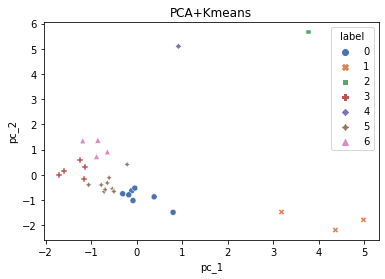

In [3]:
pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(vecs)
print("Explained variance:", sum(pca.explained_variance_ratio_))
kmeans_pca = kmeans_method(pca_vecs)
print("\nCluster centers:")
for clust in kmeans_pca.cluster_centers_:    
    print(kmeans_pca.predict(np.array([clust], dtype=np.float32))[0], "-",m.wv.most_similar(positive=[pca.inverse_transform(clust),], topn=2))

print("\nKmeans PCA clusters: \n")
pca_dict = print_data_labels(kmeans_pca, test_docs)

calc_variance(kmeans_pca, pca_dict)

plot(kmeans_pca, pca_vecs, title='PCA+Kmeans')

DUNN:  1.6822742264975856
Silhouette mean:  0.37314302
Silhouette samples: [ 0.4476598   0.39070302  0.42904404 -0.69937307  0.54783005  0.713996
  0.30447578  0.42319882  0.7703072   0.40596324  0.35606775  0.51209444
 -0.4365662   0.61582506  0.49965334  0.30919257  0.6591774   0.6591771
  0.6732014   0.47662538  0.7492901   0.4937162   0.52225417 -0.7789605
 -0.13722049 -0.505528    0.7071847   0.74829215  0.518369    0.44196907
  0.58997005  0.5329866 ]

OPTICS+PCA clusters:
-1 [['easter'], ['geology'], ['games'], ['easter', 'eggs'], ['search', 'engines']]
0 [['space'], ['chemistry'], ['english']]
1 [['psychology'], ['psychotherapy']]
2 [['electricity'], ['travel']]
3 [['geography'], ['ships']]
4 [['languages'], ['religion']]
5 [['education'], ['education'], ['health']]
6 [['computers'], ['smartphones']]
7 [['internet'], ['google']]
8 [['vaccinations'], ['flu']]
9 [['social', 'networks'], ['browsers']]
10 [['ancient', 'rome'], ['ancient', 'world'], ['ancient', 'greece']]
11 [['cryp

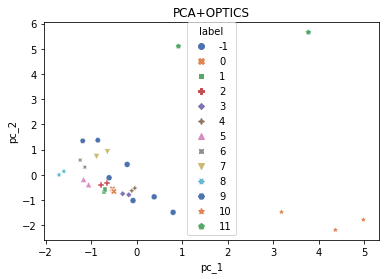

In [4]:
optics = method_train_test(OPTICS(min_samples=2), pca_vecs)
print("\nOPTICS+PCA clusters:")
calc_variance(optics, print_data_labels(optics, test_docs))
plot(optics, pca_vecs,title='PCA+OPTICS')


DUNN:  1.0853002177017985
Silhouette mean:  0.3024548
Silhouette samples: [ 0.7041685   0.63753116  0.69434917  0.60439634 -0.04416502  0.71251583
  0.4145425   0.57539374  0.14422514  0.66252935  0.5519107   0.0217625
 -0.73867595  0.5885778   0.5748517  -0.31927627  0.20747164  0.20747198
  0.783961    0.07796828  0.8208658   0.01909459  0.58485687  0.34372276
 -0.5749149  -0.80110025  0.7131354   0.18041518 -0.27952826  0.31241968
  0.64079386  0.65728253]

DBSCAN clusters: 
-1 [['cryptocurrency'], ['ancient', 'rome'], ['ancient', 'world'], ['geology'], ['memes'], ['easter', 'eggs'], ['search', 'engines'], ['ancient', 'greece']]
0 [['space'], ['languages'], ['geography'], ['easter'], ['chemistry'], ['ships'], ['electricity'], ['religion'], ['travel'], ['education'], ['education'], ['games'], ['english'], ['health'], ['psychology'], ['psychotherapy']]
1 [['internet'], ['computers'], ['google'], ['smartphones']]
2 [['social', 'networks'], ['browsers']]
3 [['vaccinations'], ['flu']]

V

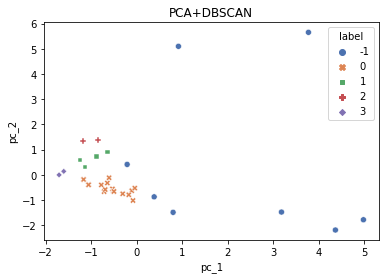

In [5]:
dbscan = method_train_test(DBSCAN(eps=0.4,min_samples=2), pca_vecs)
print("\nDBSCAN clusters: ")
calc_variance(dbscan, print_data_labels(dbscan, test_docs))
plot(dbscan, pca_vecs,title='PCA+DBSCAN')

Just for the sake of it, I ran KMeans on TSNE output. It is usually not recommended because TSNE doesn't capture the distance between points or the density.

Best k: 5
DUNN:  0.8830806801616303
Silhouette:  0.26192975
Silhouette samples: [ 0.34332174  0.36053976  0.30108222  0.10435899  0.19402502  0.02992948
  0.2296213   0.3613817   0.3892066  -0.00900961  0.05827089  0.29739496
  0.14584716  0.5306607   0.12481807  0.17671706  0.16474879  0.21253212
  0.02534368  0.06979526  0.33607516  0.4975668   0.33336487  0.16508332
  0.2744833   0.3797987   0.4163189   0.28669843  0.17809057  0.5150014
  0.45988685  0.42879802]
Kmeans TSNE clusters: 

0 [['easter'], ['chemistry'], ['ancient', 'rome'], ['religion'], ['education'], ['easter', 'eggs'], ['health'], ['psychotherapy']]
1 [['ships'], ['travel'], ['education'], ['vaccinations'], ['computers'], ['google'], ['search', 'engines'], ['ancient', 'greece']]
2 [['space'], ['cryptocurrency'], ['social', 'networks'], ['electricity'], ['english']]
3 [['internet'], ['flu'], ['browsers'], ['games'], ['psychology']]
4 [['languages'], ['geography'], ['ancient', 'world'], ['geology'], ['memes'], ['smartph

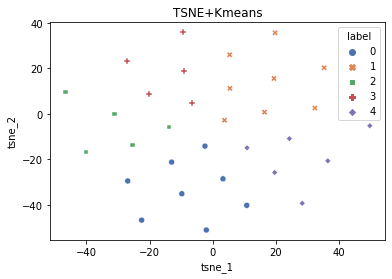

In [6]:
tsne = TSNE(n_components=2)
tsne_vecs = tsne.fit_transform(vecs)
kmeans_tsne = kmeans_method(tsne_vecs)
print("Kmeans TSNE clusters: \n")
calc_variance(kmeans_tsne, print_data_labels(kmeans_tsne, test_docs))
plot(kmeans_tsne, tsne_vecs,title='TSNE+Kmeans', columns=['tsne_1', 'tsne_2'])
